In [7]:
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
# from scipy import *
import scipy.linalg
from scipy.optimize import minimize
from scipy.linalg import eig, eigh

from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

#import scaleogram as scg
import matplotlib.pyplot as plt
import warnings

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [2]:
warnings.simplefilter('ignore')

# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [237]:
dt = 450*10
data_full = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7007-2*450:7007+dt]
# data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[3785:8000]
# data = pd.read_csv('data/home_lin_10_lac.csv', delimiter =';', decimal=',')[:]
frecuency = len(data)/(data['time'].values[-1]-data['time'].values[0])
assert 490 < frecuency < 510

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
_std = (sum((x_acc - _m)**2)/len(x_acc))**.5

x_acc = (x_acc-_m)
t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

In [238]:
def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [239]:
# accel_ssa = SSA(x_acc, 500)
# x_acc_clear = accel_ssa.reconstruct(slice(0,5))

In [240]:
X = HankelMatrix(x_acc,750)

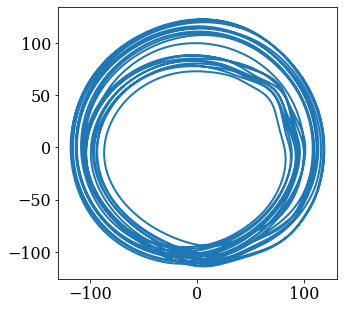

In [271]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X)
plt.plot(X_PCA[:,0],X_PCA[:,1]);

In [272]:
def Trigonometric_series(w):
    w = w.reshape((int(len(w)/2),2))*20
    phi = np.linspace(0,2*np.pi,1000)
    x_ph = np.zeros(1000)+0j

    for k in range(len(x_ph)):    
        ans = 0 
        for i in range(len(w)):
            ans += w[i,0]*np.sin(i*phi[k]) + w[i,1]*np.cos(i*phi[k])*1j
        x_ph[k] = ans
        
    x_ph = x_ph.reshape((len(x_ph),1))

    x_ph = np.concatenate((np.real(x_ph), np.imag(x_ph)), axis=1)
    
    return x_ph

def Loss(w):
    x_ph = Trigonometric_series(w)
    nn = NearestNeighbors(n_neighbors = 12).fit(X_PCA)
    dists, idxs = nn.kneighbors(x_ph)
    return np.sum(dists**2)   

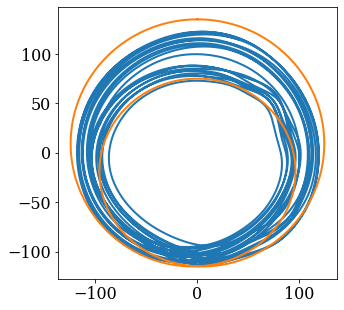

In [346]:
plt.plot(X_PCA[:,0],X_PCA[:,1])

x_tr = Trigonometric_series(np.array([ 0.  , -0.25,  0.5,  1,  5.5,  5.5,  0.5,  0.5,0,0,0,0]))
plt.plot(x_tr[:,0],x_tr[:,1])
plt.show()

In [ ]:
w0 = np.array([ 0.  , -0.22,  0.66,  0.99,  5.28,  5.28,0.5,0.5])
w0 = np.array([ 0.  , -0.82,  1.04,  0.18,  4.95,  4.93, -0.17,  0.26,  0.7 , 0.7 ,  0.36,  0.38])


w0 = np.array([ 0.  , -0.25,  0.5,  1,  5.5,  5.5,  0.5,  0.5,  0,  0,  0,  0])

Optimization terminated successfully.
         Current function value: 93928.176983
         Iterations: 1701
         Function evaluations: 2360


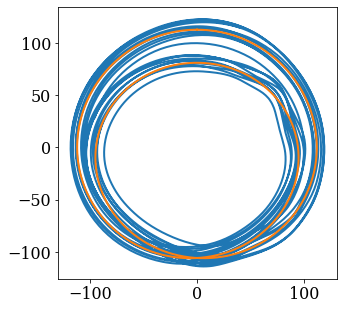

In [347]:
w0 = np.array([ 0.  , -0.25,  0.5,  1,  5.5,  5.5,  0.5,  0.5,  0,  0,  0,  0])
res1 = minimize(Loss, w0,
               method='nelder-mead',
               options={'xtol': 1e-3, 'disp': True})

plt.plot(X_PCA[:,0],X_PCA[:,1])

x_ph_fitted = Trigonometric_series(res1.x)
plt.plot(x_ph_fitted[:,0],x_ph_fitted[:,1])


In [348]:
(res1.x).round(2)

array([ 0.01, -0.24,  0.35,  0.49,  5.17,  5.07,  0.24,  0.3 , -0.  ,
        0.01, -0.01,  0.  ])

Optimization terminated successfully.
         Current function value: 105410.918625
         Iterations: 8
         Function evaluations: 1294


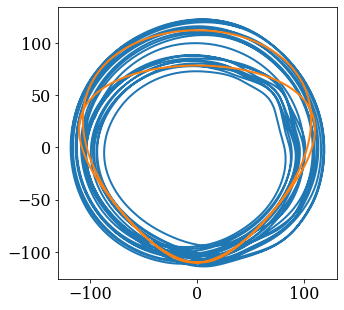

In [350]:
w0 = np.array([ 0.  , -0.25,  0.5,  1,  5.5,  5.5,  0.5,  0.5,  0,  0,  0,  0])
res2 = minimize(Loss, w0,
               method='powell',
               options={'xtol': 1e-3, 'disp': True})

plt.plot(X_PCA[:,0],X_PCA[:,1])

x_ph_fitted = Trigonometric_series(res2.x)
plt.plot(x_ph_fitted[:,0],x_ph_fitted[:,1])

In [351]:
(res2.x).round(2)

array([ 2.148e+01, -4.300e-01, -1.800e-01,  5.300e-01,  5.100e+00,
        5.130e+00,  2.000e-02,  3.400e-01,  9.700e-01,  6.000e-02,
       -1.100e-01, -3.000e-02])